# Telegram chat analysis - Hedonistic lawlessness

I've been thinking about it for a while - I can analyse everything I can/want, even frindship, support and memes. For the first step I've downloaded the whole history of the group chat from Telegram in JSON format, I will convert it to CSV, prepare some of the data to a workable format and check it. 

I also have been thinking and deceided to put every message to lowercase. I had some doubts, because "girls!" and "GIRLS!" are not the same, but for the first time of doing this - let's make it even. 

And I also going to make a vizualization with Tableau. 

So the plan is: 

1. Convert the file 

2. Preprocessing data
    - check how many messages we have
    - convert everything to the lowercase
    - check the date format 
    - what columns we need 
    - 2.1. Preprocessing conclusions.  
3. EDA 
    - 3.1. Timeline analytics 
    - 3.1.1. Chat activity  
    - 3.1.2. Month of the chat 
    - 3.1.3. Activity by hours and day of week 
    - 3.2. User Analytics
    - 3.2.1. Who sends the most
    - 3.2.2. Sticker of the chat
    - 3.2.3. Word of the Chat - the most using word
    - 3.3. Highlights of the Chat
    - 3.3.1. Message that gets most of replies
4. Conclusions. 

**Tableau vizualization**

[public.tableau](https://public.tableau.com/app/profile/lyubov1222/viz/Groupchatstory/Story1)

# 1. Convert the file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import re
import sys
import csv
import json
from datetime import datetime
import calendar
from datetime import date
import warnings

warnings.filterwarnings("ignore")

In [2]:
palette = ['#2C3333', '#395B64', '#A5C9CA', '#1D5C63', '#417D7A'
          ]
sea.set_palette(palette=palette)
sea.set_style("ticks")

In [3]:
data = pd.read_json('/Users/lqbaha/Downloads/datasets/hedonists.json')

In [4]:
data = data['messages'].apply(pd.Series)

In [5]:
data.head()

,id,type,date,date_unixtime,from,from_id,file,thumbnail,media_type,sticker_emoji,...,mime_type,duration_seconds,photo,forwarded_from,message_id,title,performer,poll,via_bot,location_information
0,-999596269,message,2022-03-29T11:20:25,1648538425,Влад Пашины-уже-не-только-друзья,user1498378,stickers/sticker.webp,stickers/sticker.webp_thumb.jpg,sticker,👐,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-999596268,message,2022-03-29T11:20:27,1648538427,Андрей,user120058113,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-999596267,message,2022-03-29T11:20:46,1648538446,Андрей,user120058113,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-999596266,service,2022-03-29T11:20:55,1648538455,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-999596265,message,2022-03-29T11:21:11,1648538471,Элина,user527336814,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print('Dataset size:', data.shape[0])

Dataset size: 32623


# 2. Preprocessing data

So from the first look our dataset contains 32 623 rows, aka messages. 

Let's start with cleaning it and checking what columns contains the necessary data. 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32623 entries, 0 to 32622
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    32623 non-null  int64  
 1   type                  32623 non-null  object 
 2   date                  32623 non-null  object 
 3   date_unixtime         32623 non-null  object 
 4   from                  32604 non-null  object 
 5   from_id               32604 non-null  object 
 6   file                  3398 non-null   object 
 7   thumbnail             3235 non-null   object 
 8   media_type            3385 non-null   object 
 9   sticker_emoji         1567 non-null   object 
 10  width                 7352 non-null   float64
 11  height                7352 non-null   float64
 12  text                  32623 non-null  object 
 13  text_entities         32623 non-null  object 
 14  actor                 19 non-null     object 
 15  actor_id           

We need to convert `data` to the correct format. 

In [8]:
data['date'] =  pd.to_datetime(data['date'], 
                               format='%Y%m%dT%H:%M:%S')

In [9]:
data['reply_to_message_id'] = data['reply_to_message_id'].astype('Int64')

In [10]:
data['from'].value_counts()

Михал Палыч Терентьев               8670
Влад Пашины-уже-не-только-друзья    5782
Картошка                            3623
Даня                                3231
lqbaha                              2660
Андрей                              2334
Олександр                           2001
Паша ПИРОЖОК                        1957
Элина                               1226
Святослав Мглинец                    458
Артем 😼 Данилов                      449
Dmitriy Gogin                        210
Пятничный сиськобот                    3
Name: from, dtype: int64

So here you go our sqad, I will rename everyone and will think is the columns `from_id` connected with comething. And yes, delete the bot, who posted three times. 

But we can see already our leaders by messages. 

In [11]:
data = data.loc[data["from"] != 'Пятничный сиськобот']

In [12]:
data['from'] = data['from'].replace(
    ['Михал Палыч Терентьев', 'Влад Пашины-уже-не-только-друзья', 'Картошка', 'Даня', 'lqbaha', 
     'Андрей', 'Олександр', 'Паша ПИРОЖОК', 'Элина', 'Святослав Мглинец', 'Артем 😼 Данилов', 
     'Dmitriy Gogin'], 
    ['Angelina', 'Vladislav', 'Maria', 'Daniil', 'Liubov', 'Andrei', 'Aleksandr', 'Pavel', 
     'Elina', 'Svyatoslav', 'Artem', 'Dmitriy'])

In [13]:
data['media_type'].value_counts()

sticker          1628
video_file        882
video_message     564
animation         214
voice_message      74
audio_file         21
Name: media_type, dtype: int64

And here we have 6 types of messages, and more than anything - we love stickers. 

But where is the photo? We have an excact column `photo`, and I think I will merge this info. 

In [14]:
data['sticker_emoji'].value_counts()

☺️    83
👍     65
😂     57
❤️    48
😆     48
      ..
📞      1
🥴      1
💸      1
🦆      1
💔      1
Name: sticker_emoji, Length: 236, dtype: int64

We are using different 236 types of stickers. 

The column `type` has only 19 different values = 'Service', I think we can rid of this one column. 
I also decided to remove these columns : `date_unixtime`, `width`, `height`, `text_entities`, `actor`, `action`, `members`, `edited`, `edited_unixtime`, `duration_seconds`, `forwarded_from`, `message_id`, `title`, `performer`, `poll`, `via_bot`, `location_information`, `mime_type`. 

In [15]:
data = data.drop(['type', 'date_unixtime', 'width', 'height', 'text_entities', 'actor', 
                 'action', 'members', 'edited', 'edited_unixtime', 'duration_seconds', 
                 'forwarded_from', 'message_id', 'title', 'performer', 'poll', 'via_bot', 
                 'location_information', 'mime_type', 'actor_id'], axis=1)

In [16]:
data['text'] = data['text'].str.lower()

In [17]:
for d in data['photo'].unique():
    data.loc[(data['photo'] == d) & (data['media_type'].isna()), 'media_type'] = \
    'photo'

In [18]:
data['media_type'].value_counts()

photo            4053
sticker          1628
video_file        882
video_message     564
animation         214
voice_message      74
audio_file         21
Name: media_type, dtype: int64

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32620 entries, 0 to 32622
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   32620 non-null  int64         
 1   date                 32620 non-null  datetime64[ns]
 2   from                 32601 non-null  object        
 3   from_id              32601 non-null  object        
 4   file                 3396 non-null   object        
 5   thumbnail            3233 non-null   object        
 6   media_type           7436 non-null   object        
 7   sticker_emoji        1567 non-null   object        
 8   text                 31755 non-null  object        
 9   reply_to_message_id  9063 non-null   Int64         
 10  photo                4053 non-null   object        
dtypes: Int64(1), datetime64[ns](1), int64(1), object(8)
memory usage: 3.0+ MB


In [20]:
print('Dataset size:', data.shape[0])

Dataset size: 32620


## 2.1. Preprocessing conclusions. 

So I removed 20 columns with unecessary information, convert every text message to the lower case and added to the column `media_type` type "photo" from the `photo` column. 

And here we have our dataframe cleaned and ready to work with. 

We have 32 620 rows = messages, 7 types of media and 12 users. 



# 3. EDA

## 3.1. Timeline analytics

First of all let's see the timing of our chat. 

In [21]:
print('Start date of the chat:', data['date'].min())
print('The whole communication period: ', data['date'].max() - data['date'].min())

Start date of the chat: 2022-03-29 11:20:25
The whole communication period:  337 days 01:25:23


So it's been almost a year of our time here. 

## 3.1.1. Chat activity

And we send around 32,5K messages which brings us: 

In [22]:
print(round(
    data.shape[0] / float((data['date'].max() - data['date'].min()).days),2), 'messages per day')

96.8 messages per day


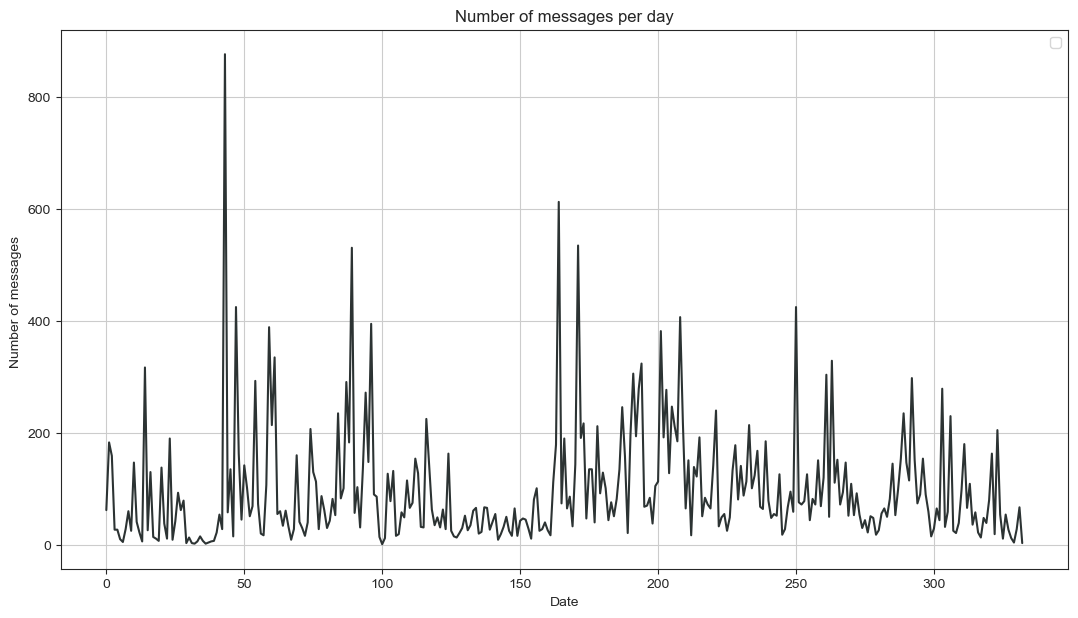

In [23]:
chat_period = data.pivot_table(index=data['date'].dt.date, values="id", aggfunc="count").reset_index()

plt.figure(figsize=(13,7))
sea.lineplot(data=chat_period)
plt.title("Number of messages per day")
plt.xlabel("Date")
plt.ylabel("Number of messages ")
plt.grid(True)
plt.legend("")
plt.show()

Beautiful. Let's find some statistics here:

In [24]:
chat_period.describe()

,id
count,333.000000
mean,97.957958
std,103.861084
min,1.000000
25%,30.000000
50%,65.000000
75%,133.000000
max,877.000000


In [25]:
chat_period.sort_values('id', ascending = False).head(5)

,date,id
43,2022-05-16,877
164,2022-09-14,613
171,2022-09-21,535
89,2022-07-01,531
47,2022-05-20,425


So in average - we send around 100 messages per day to the chat. 

* The maximum was 877 - on May 16, 2022 - here was review everyone's tinder profiles. I can guess, that here would be also a peak of photos sent. 
* Second place take September 14, 2022, - Elina began a serious discussion of the concept of rest and relaxation processes and new feature of iPhones to make stickers from photos
* Third - September 21, 2022 - first news about mobilisation and iconic chat mem about Angelina's jokes
* Fourth - July 01, 2022 - chaotic discussion and first attempt at censorship
* And Fifth - May 20, 2022 - discussion of burgers and why Angelina is trying to be a veggie




## 3.1.2. Month of the chat

let's see how our activity is distributed by months.

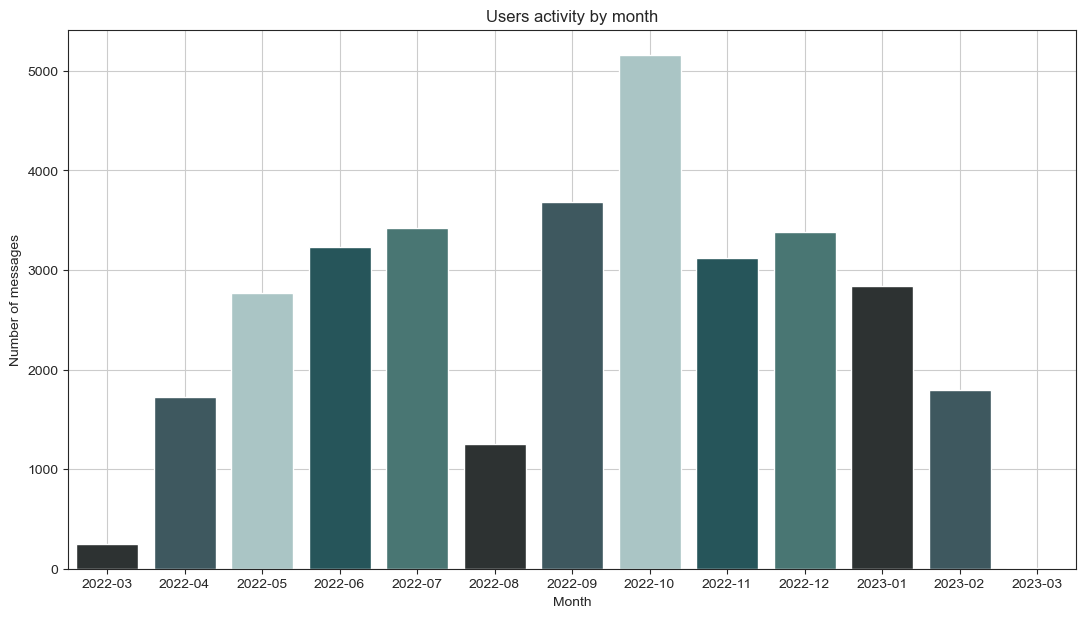

In [26]:
chat_month = data.pivot_table(index=data['date'].dt.strftime('%Y-%m'), values="id", aggfunc="count")

plt.figure(figsize=(13,7))
sea.barplot(x=chat_month.index,y=chat_month["id"], palette = palette)
plt.title("Users activity by month")
plt.xlabel("Month")
plt.ylabel("Number of messages")
plt.grid(True)
plt.show()

So even that our outliers messages per day are in May and September - the most active month in our chat is October 2022 - 5155 messages. 

And the most silence month is August of 2022, probably because everyone is busy on vacation (we were on a hike out of touch).  

## 3.1.3. Activity by day of week and hours

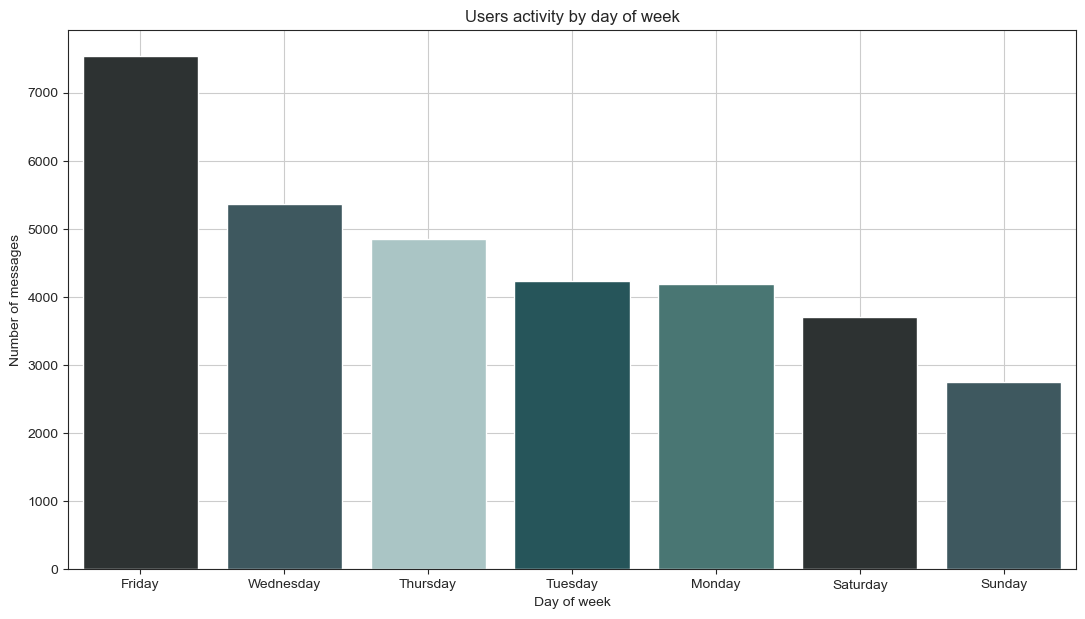

In [27]:
chat_day =  data.pivot_table(
    index=data['date'].dt.day_name(), values="id", aggfunc="count").sort_values(
    by='id', ascending = False)

plt.figure(figsize=(13,7))
sea.barplot(x=chat_day.index,y=chat_day["id"], palette = palette)
plt.title("Users activity by day of week")
plt.xlabel("Day of week")
plt.ylabel("Number of messages")
plt.grid(True)
plt.show()

So we talk the most on Fridays (7542 messages for all of the fridays), and the least - on Sunday. 

But let's make the same graph, but with average data. 

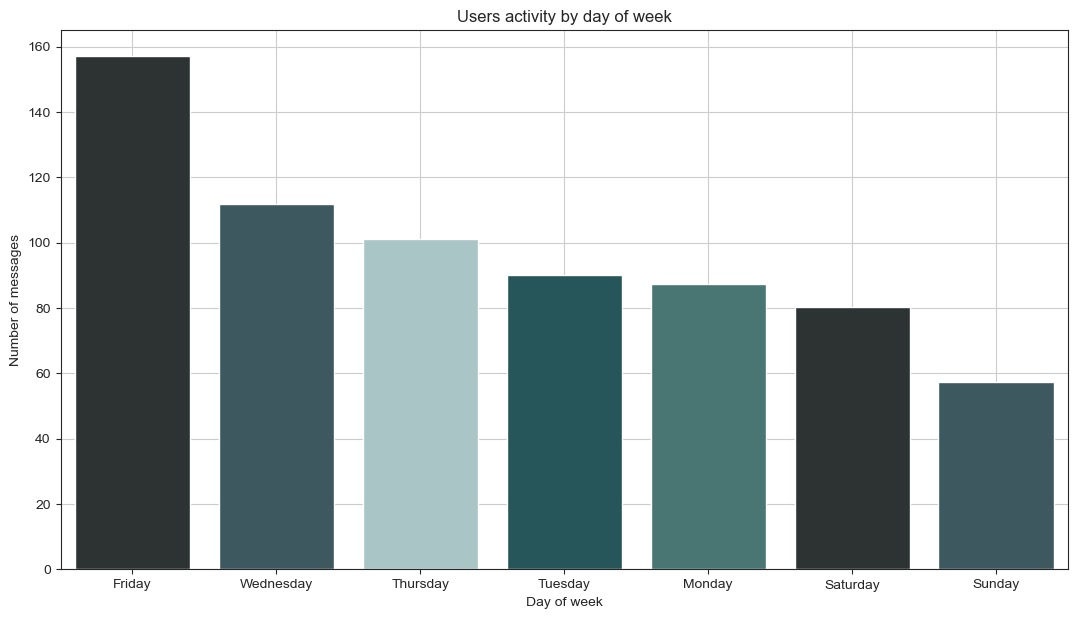

In [28]:
chat_period['date'] = pd.to_datetime(chat_period['date'], format='%Y-%m-%d')
chat_period['day_of_week'] = chat_period['date'].dt.day_name()
chat_period_pivot = chat_period.groupby(
    ["day_of_week"]).agg({"id":"mean"}).reset_index().sort_values(by='id', ascending = False)

plt.figure(figsize=(13,7))
sea.barplot(x=chat_period_pivot['day_of_week'],y=chat_period_pivot["id"], palette = palette)
plt.title("Users activity by day of week")
plt.xlabel("Day of week")
plt.ylabel("Number of messages")
plt.grid(True)
plt.show()

And here we can see a confirmation.  And what's about timing? 

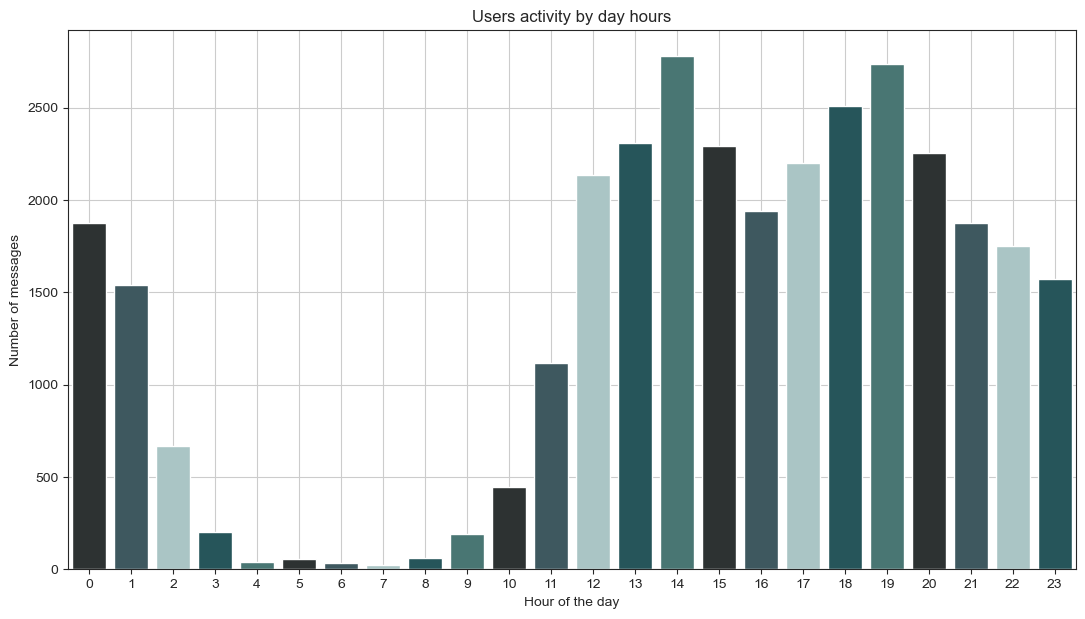

In [29]:
chat_time =  data.pivot_table(
    index=data['date'], values="id", aggfunc="count").reset_index().sort_values(
    by='id', ascending = False)
chat_time['time_hour'] = pd.to_datetime(chat_time['date']).dt.hour

chat_time_pivot = chat_time.groupby(
    ["time_hour"]).agg({"id":"sum"}).reset_index().sort_values(by='time_hour', ascending = True)

plt.figure(figsize=(13,7))
sea.barplot(x=chat_time_pivot['time_hour'],y=chat_time_pivot["id"], palette = palette)
plt.title("Users activity by day hours")
plt.xlabel("Hour of the day")
plt.ylabel("Number of messages")
plt.grid(True)
plt.show()

At least we have our hours of sleep and having our conversations from the lunch time. 

And we can go to the next part. 

## 3.2 User Analytics

Now let's take a look to our actions. 

## 3.2.1. Who sends the most. 


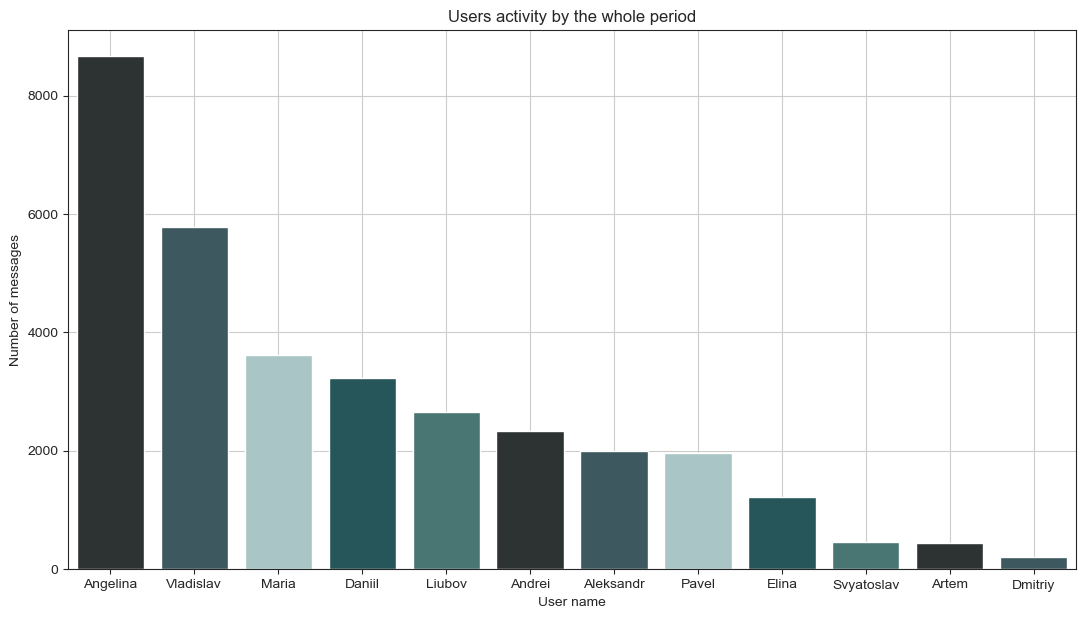

In [30]:
chat_users = data.pivot_table(
    index="from", values="id", aggfunc="count").sort_values(by="id", ascending=False)


plt.figure(figsize=(13,7))
sea.barplot(x=chat_users.index,y=chat_users["id"], palette = palette)
plt.title("Users activity by the whole period")
plt.xlabel("User name")
plt.ylabel("Number of messages")
plt.grid(True)
plt.show()

Here we have our most active users. But let's take a look at the type of sending media. 

In [31]:
medias = list(filter(lambda x: str(x) != 'nan', list(data['media_type'].unique())))

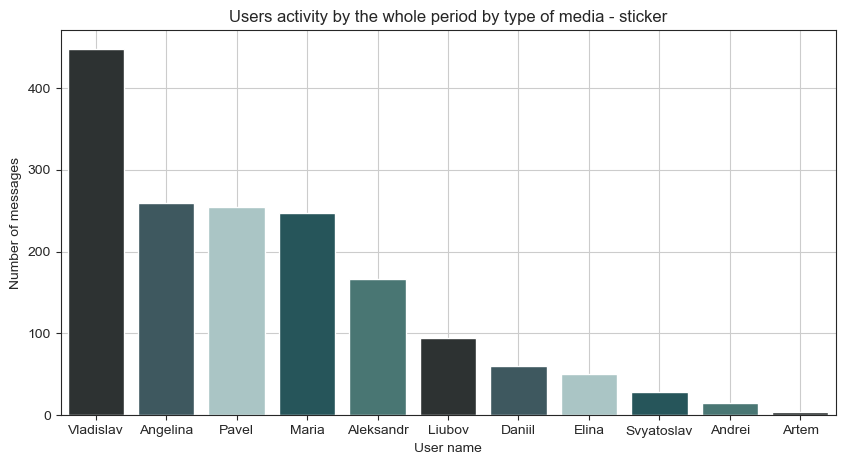

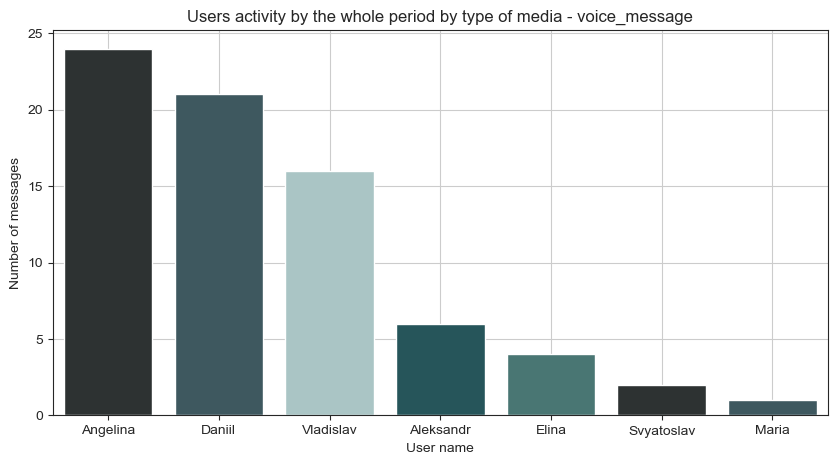

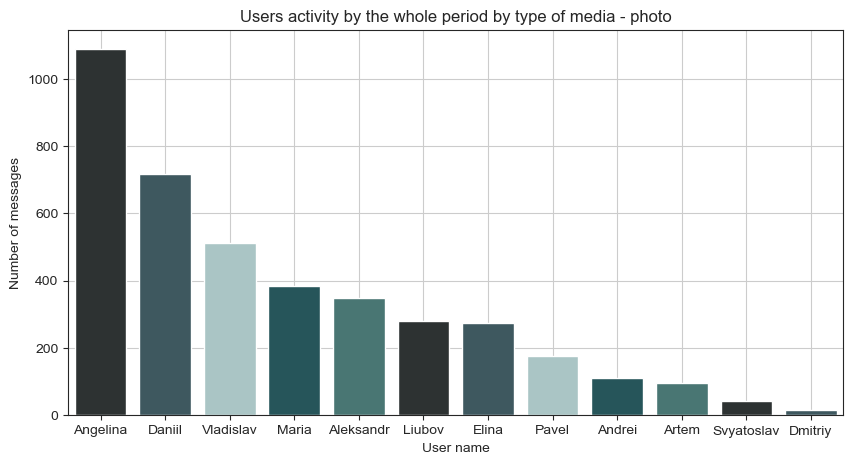

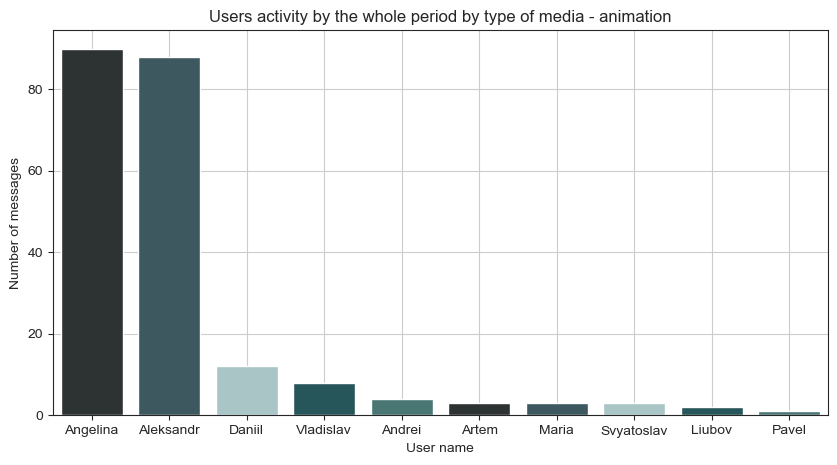

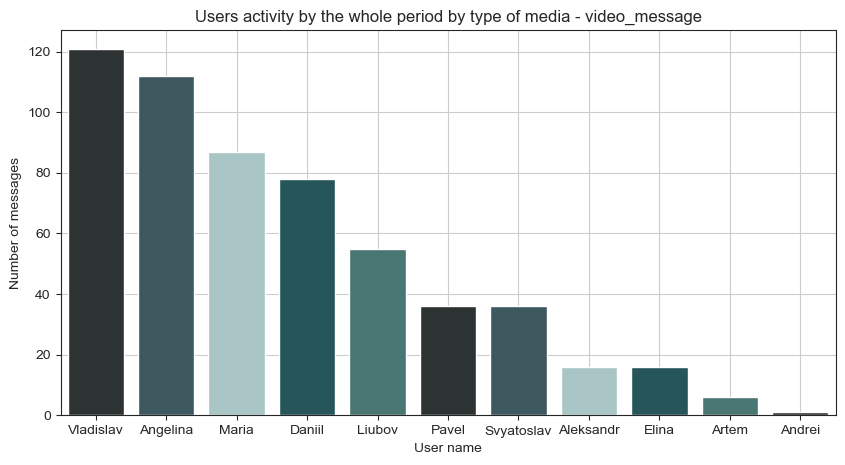

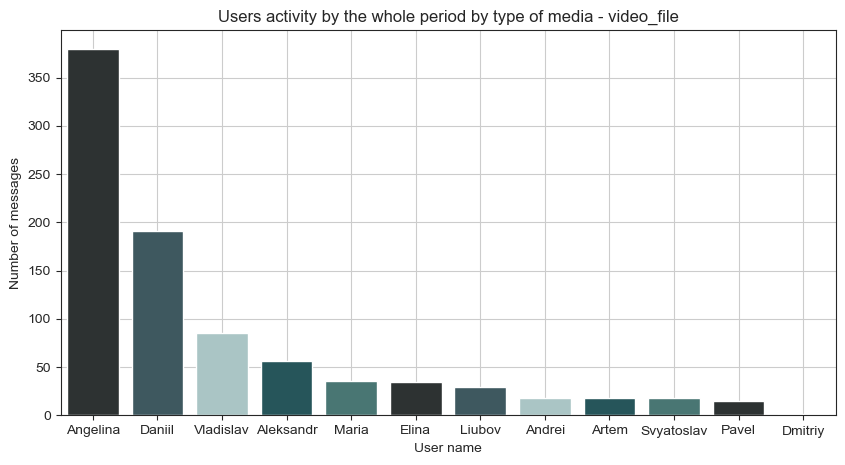

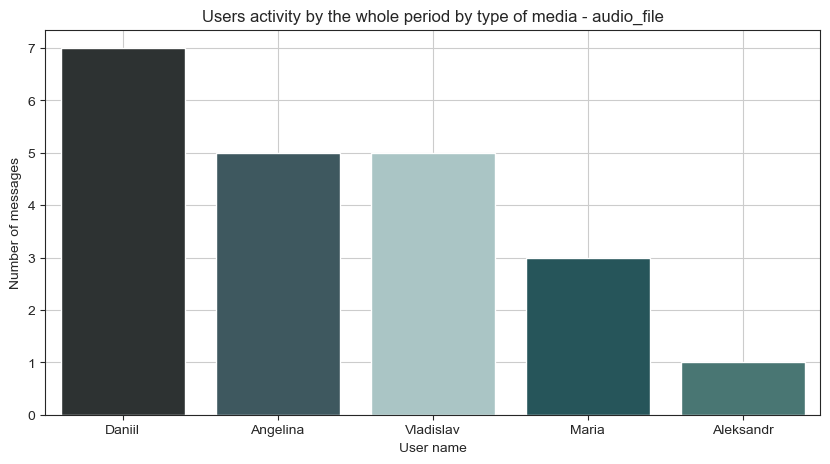

In [32]:
for i in enumerate(medias): 
    chat_users = data[data.media_type == i[1]].pivot_table(
        index="from", values="id", aggfunc="count").sort_values(by="id", ascending=False)

    plt.figure(figsize=(10,5))
    sea.barplot(x=chat_users.index,y=chat_users["id"], palette = palette)
    plt.title(f"Users activity by the whole period by type of media - {i[1]}")
    plt.xlabel("User name")
    plt.ylabel("Number of messages")
    plt.grid(True)


And here we have our friend who is sending the most: 

- sticker - **Vlad**
- voice_message - **Angelina, Daniil, Vlad**
- photo - **Angelina**
- animation - **Angelina and Aleksandr** 
- video_message - **Vlad, Angelina and Maria**
- video_file - **Angelina**
- audio_file - **Daniil**

## 3.2.2. Sticker of the chat. 

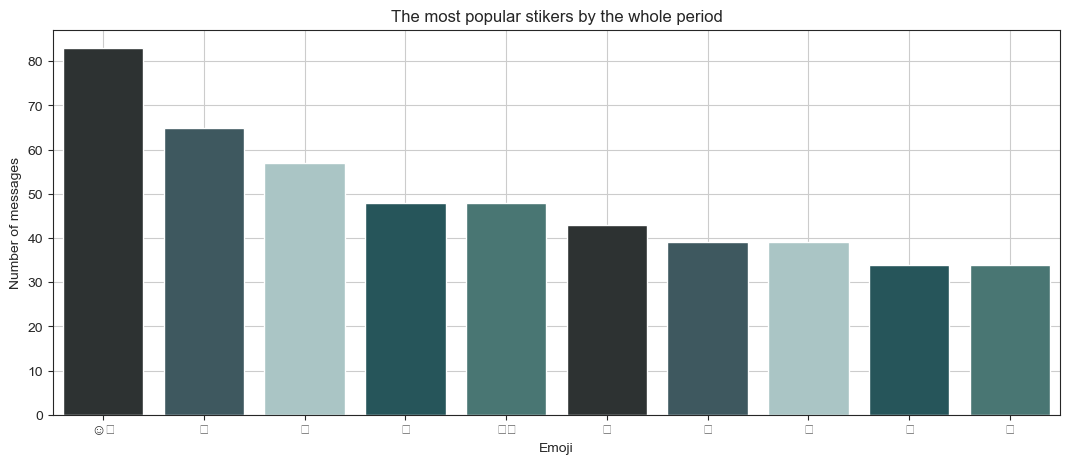

In [33]:
emoji = data.pivot_table(
    index="sticker_emoji", values="id", aggfunc="count").sort_values(by="id", ascending=False)
emoji = emoji.head(10)

plt.figure(figsize=(13,5))
sea.barplot(x=emoji.index,y=emoji["id"], palette = palette)
plt.title("The most popular stikers by the whole period")
plt.xlabel("Emoji")
plt.ylabel("Number of messages")
plt.grid(True)
plt.show()

So it could be clearly I'm leaving here these stikers. 

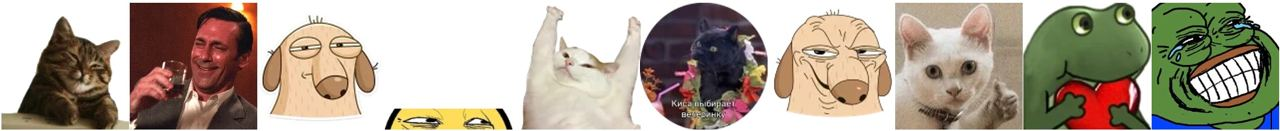

## 3.2.3. Word of the Chat

In [34]:
#pip install wordcloud

In [35]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [36]:
data_text = data.text.dropna()

In [37]:
text = " ".join(
    review for review in data.text.dropna() if review is not None and type(review) == str)

In [38]:
print("There are {} words in all the messages.".format(len(text)))

There are 781841 words in all the messages.


In [39]:
stopwords = set(STOPWORDS)
stopwords.update(["и", "за", "в", "я", "на", "как", "ты","ты","но","от", "для", "то", 
                  "у", "не", "нет", "да", "про","где","нас","через","бы", "еще", "о",
                  "это", "что","то","его","ее","нам","тебе", "по", "так", "к","они", 
                  "он","с","из","же","так","а","там","ну","или","она","без", "меня", 
                  "уже", "чтобы", "кто", "даже", "чем", "если", "тут", "тебя", "вот", 
                  "вы", "мне", "все", "кто", "ещё", "под", "эти", "после", "эти", "мой", 
                  "тоже", "всё", "когда", "к", "их", "прям", "только", "либо", "до", "ж", 
                  "потому", "него", "куда", "них", "раз", "был", "была", "были", "вас", 
                  "туда", "было", "себя", "ему", "чего",  "вам", "того", "при", "этот", 
                  "эта", "этого", "оно", "хотя", "какой", "такие", "со", "эту", "сама", "2",
                  "сам", "какая", "всем", "всех", "такая", "такой", "шо", "ага", "хоть", "моя",
                  "потом", "чо", "может", "че", "во", "вроде", "этом", "кого", "ли", "пэтому", 
                  "об", "себе", "им", "ни", "эт", "щас", "быть", "м", "почти", "который", "ок", 
                  "можно", "надо", "кстати", "просто", "будет", "могу", "хочу", "кстати", 
                  "очень", "тогда", "сейчас", "всегда", "вообще", "мои", "мб", "точно", "ща", "есть", "3"])

In [40]:
data_text["words"] = data['text'].str.replace('[^\w\s]','')
 
new_data = data_text.words.str.split(expand=True).stack().value_counts().reset_index()
new_data.columns = ['Word', 'Frequency'] 
 
new_data.query('Word not in @stopwords').head(10)

,Word,Frequency
18,мы,755
28,бля,446
49,типа,285
61,сегодня,225
64,спасибо,219
67,пиздец,202
76,почему,175
78,пока,170
79,лол,166
80,теперь,166


In [41]:
def setListOfcolor_func(word=None, font_size=None,  
                     position=None, orientation=None,  
                     font_path=None, random_state=None):  
    color_list = ['#2C3333', '#395B64', '#A5C9CA', '#1D5C63', '#417D7A']  
    return np.random.choice(color_list)  

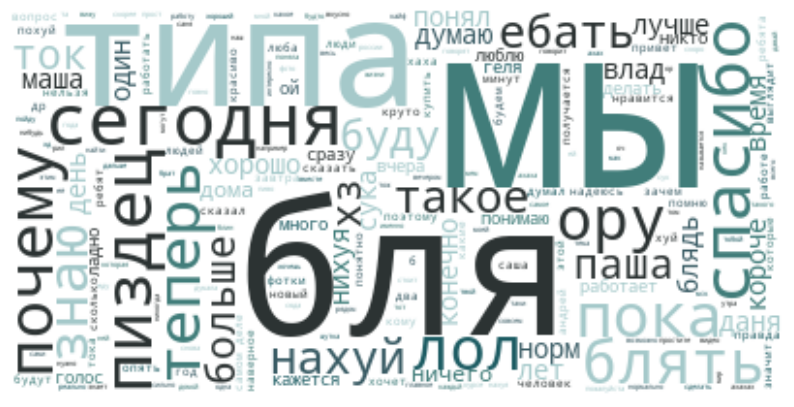

In [42]:
wordcloud = WordCloud(
    stopwords=stopwords, 
    background_color="white", 
    color_func=setListOfcolor_func).generate(text)

plt.figure( figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

So yeah, this is our words. 

It was quite hard to create the stop words, because we have them a lot. But it was so fun. 

## 3.3. Highlights of the Chat

## 3.3.1. Message that gets most of replies

I will get top-3 messages, which gets most of replies. 


In [43]:
replies = data.pivot_table(index="reply_to_message_id", values="id", aggfunc="count").reset_index()
replies = replies.sort_values(by= "id", ascending = False).head(3)
replies_list = list(replies['reply_to_message_id'])
replies

,reply_to_message_id,id
2978,-999537193,13
1969,-999559609,9
5404,-999497888,6


In [44]:
data.query('id in @replies_list')

,id,date,from,from_id,file,thumbnail,media_type,sticker_emoji,text,reply_to_message_id,photo
9334,-999559609,2022-07-08 13:37:37,Angelina,user409664461,NaN,NaN,NaN,NaN,не расставались мы ниразу\nмы ругались \nно не...,-999559611,NaN
13781,-999537193,2022-09-14 18:22:37,Andrei,user120058113,NaN,NaN,NaN,NaN,тогда еще стульями кидались,<NA>,NaN
23630,-999497888,2022-11-22 10:23:06,Elina,user527336814,NaN,NaN,photo,NaN,,<NA>,photos/photo_2961@22-11-2022_10-23-06.jpg


1. 14 of September, remember, it's one of our peaks in number of messages sent per day. And all the replies was a photos, from one of our night in a bar (+ diploma of Pavel, Vlad and Daniil). 

2. Message from Angelina about "this is our first breakup with Vlad" and then Daniil comes with huge amount of proofs of her messages "we broke up" and "we broke up again". 

3. Photo from Elina - they got married! 

## 4. Conclusions. 

So first of all - it was a lot of fun doing this project. 

I downloaded the whole file of the chat history, converted it to csv, and removed 20 columns with unecessary information, convert every text message to the lower case and added to the column media_type type "photo" from the photo column.


- We have 32 620 rows = messages, 7 types of media and 12 users.
- We are using different 236 types of stickers.


- Start date of the chat: 2022-03-29 11:20:25
- The whole communication period:  337 days, so it's been almost a year of our time here.

- So in average - we send around 100 messages per day to the chat.


**Timeline highlights** 

1. 877 messages - on May 16, 2022 - here was review everyone's tinder profiles. I can guess, that here would be also a peak of photos sent.
2. 613 messages - September 14, 2022, - Elina began a serious discussion of the concept of rest and relaxation processes and new feature of iPhones to make stickers from photos
3. 535 messages - September 21, 2022 - first news about mobilisation and iconic chat mem about Angelina's jokes
4. 531 messages - July 01, 2022 - chaotic discussion and first attempt at censorship
5. 425 messages - May 20, 2022 - discussion of burgers and why Angelina is trying to be a veggie

**Timeline by month, days and hours** 

* So even that our outliers messages per day are in May and September - the most active month in our chat is October 2022 - 5155 messages.  And the most silence month is August of 2022, probably because everyone is busy on vacation (we were on a hike out of touch). 

* So we talk the most on Fridays (7542 messages for all of the fridays), and the least - on Sunday.

* At least we have our hours of sleep and having our conversations from the lunch time.

**User activity** 

And here we have our friend who is sending the most:
- messages in general - Angelina
- sticker - Vlad
- voice_message - Angelina, Daniil, Vlad
- photo - Angelina
- animation - Angelina and Aleksandr
- video_message - Vlad, Angelina and Maria
- video_file - Angelina
- audio_file - Daniil

**Top-10 stickers**

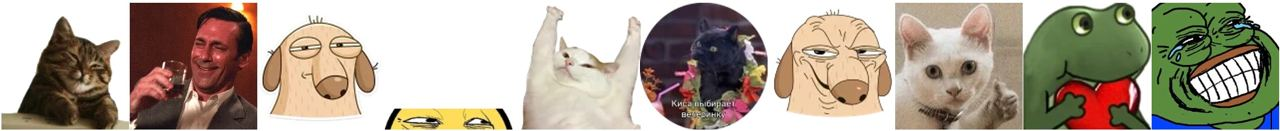

**Words of the chat**

There are 781841 words in all the messages. And the most common: 
1. мы	755
2. бля	446
3. типа	285
4. сегодня	225
5. спасибо	219
6. пиздец	202
7. почему	175
8. пока	170
9. лол	166
10. теперь	166

I didn't remove word "we", because mostly we use it not as pronoun, but a meme. 

**Most replied messages**

1. 14 of September, remember, it's one of our peaks in number of messages sent per day. And all the replies was a photos, from one of our night in a bar (+ diploma of Pavel, Vlad and Daniil). 

2. Message from Angelina about "this is our first breakup with Vlad" and then Daniil comes with huge amount of proofs of her messages "we broke up" and "we broke up again". 

3. Photo from Elina - they got married! 

And let's save it to csv so I could make an interactive Tableau lists. 

In [45]:
data.to_csv('/Users/lqbaha/Downloads/datasets/hedonists_chat.csv')

In [46]:
new_data = new_data.query('Word not in @stopwords')
new_data.to_csv('/Users/lqbaha/Downloads/datasets/word_cloud.csv')